# Packages

conda create --name meeg python
conda activate meeg

pip install pandas==2.2.2
pip install joblib==1.4.2
pip install lxml==5.3.0
pip install nibabel==5.2.1
pip install scipy==1.14.1
pip install scikit-learn==1.5.1
pip install requests==2.32.3
pip install mne==1.8.0
pip install mne-qt-browser==0.6.3
pip install openpyxl==3.0.15
pip install pyqt6==6.7.1
pip install pyvista==0.44.1
pip install pyvistaqt==0.11.1
pip install ipywidgets==8.1.5

In [3]:
import numpy as np
import mne
from mne.datasets import fetch_fsaverage, sample
import os.path as op
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.io.wavfile import read
import pandas as pd
#import nibabel
#import nilearn
import spacy


# Data

## load data

In [4]:
# connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')


In [5]:
# data is saved in multiple file (-1.fif) due to the huge size but this funtion reads all of them automatically
basePath = "C:/StudyMaster/SeminarStimulate/EEG_analysis/"
#basePath = "G:/My Drive/Semester3/SeminarStimulate/eeg_analysis/"
file = basePath + "Achim_raw.fif"  #TODO: input file path
data = mne.io.read_raw_fif(file, preload=True)

Opening raw data file C:/StudyMaster/SeminarStimulate/EEG_analysis/Achim_raw.fif...
    Range : 0 ... 8254999 =      0.000 ...  3302.000 secs
Ready.
Opening raw data file C:\StudyMaster\SeminarStimulate\EEG_analysis\Achim_raw-1.fif...
    Range : 8255000 ... 9604199 =   3302.000 ...  3841.680 secs
Ready.
Reading 0 ... 9604199  =      0.000 ...  3841.680 secs...


In [6]:
# get information about the data
data.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 63 EEG, 2 misc
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 690.0 Hz
 meas_date: 2024-07-26 16:09:22 UTC
 meas_id: 4 items (dict)
 nchan: 65
 projs: []
 sfreq: 2500.0 Hz
>

## Plot EEG channels and stimuli channel

In [7]:
eeg_data = data.copy().pick("eeg")
stimuli_channel = data.copy().pick(["65"])

In [8]:
%matplotlib qt

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

Using matplotlib as 2D backend.


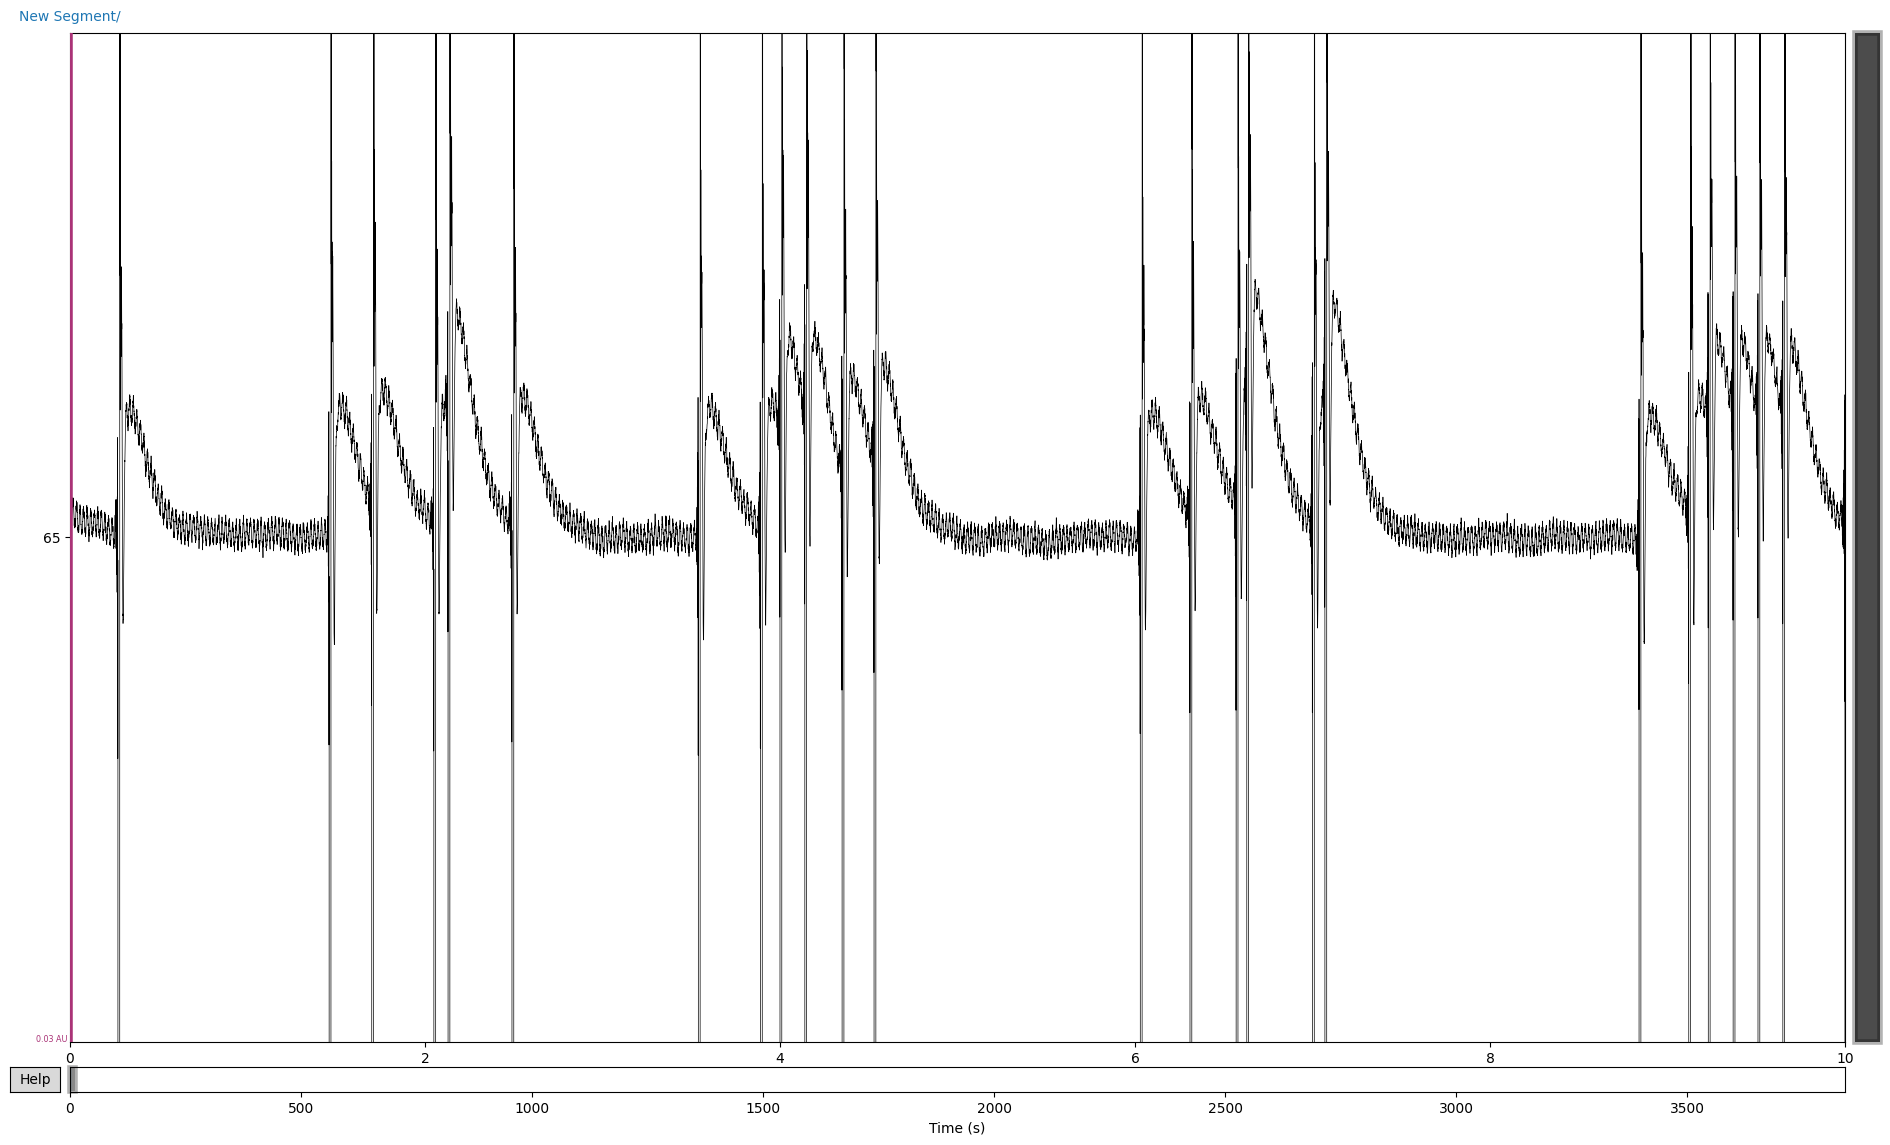

In [11]:
data.plot()
stimuli_channel.plot()

# Preprocessing

### Bandpass Filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 8251 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Using matplotlib as 2D backend.


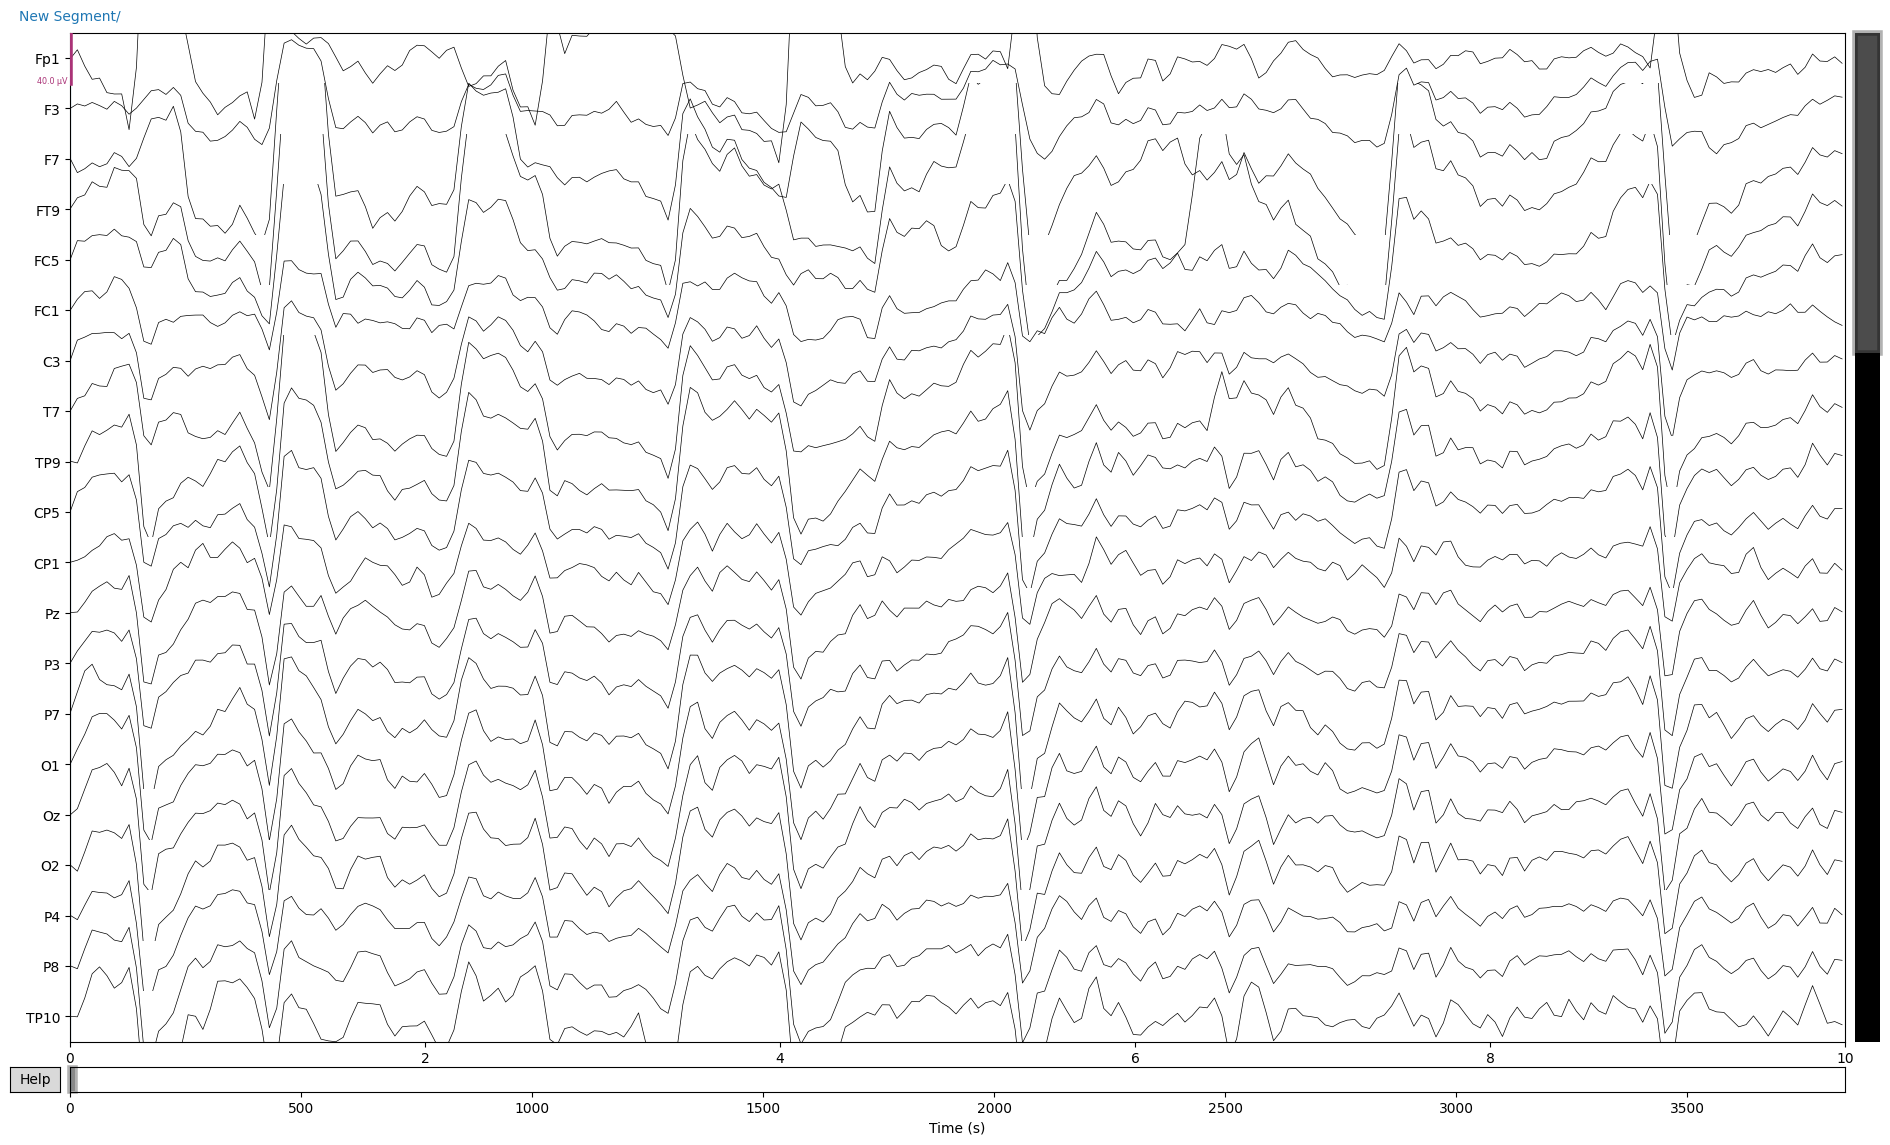

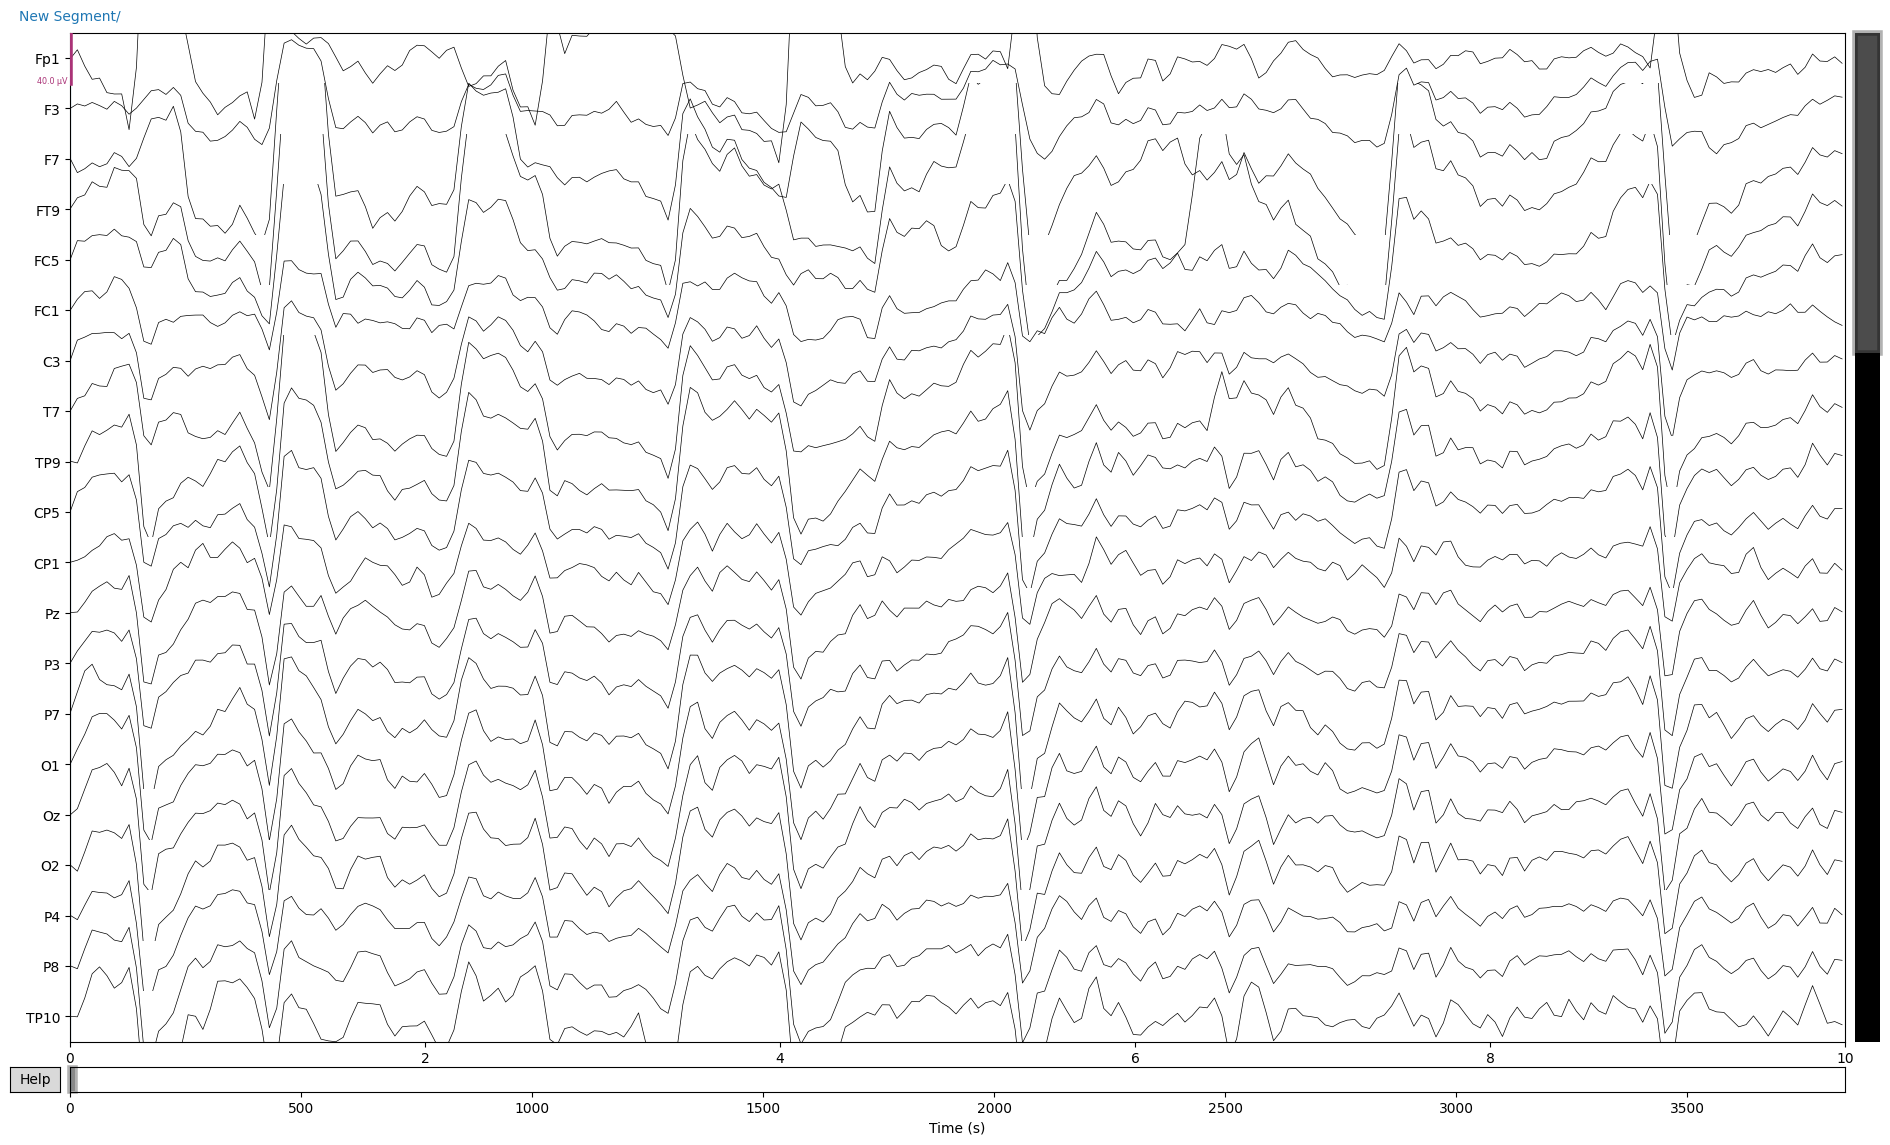

In [9]:
bandPassFilterLow = 1
bandPassFilterHigh = 8
eeg_data = eeg_data.filter(bandPassFilterLow, bandPassFilterHigh) #TODO: add suitable low and high frequencies for a band-pass filter
eeg_data.plot()

### Downsample Data

In [10]:
fsamp = 200
eeg_data = eeg_data.resample(fsamp, npad="auto")

### Independent Component Analysis (ICA)

In [11]:
ica = mne.preprocessing.ICA(n_components=30, random_state=97, method="fastica")
ica.fit(eeg_data)

ImportError: The sklearn package is required to use method='fastica', package was not found

#### Find Eye Artefacts

In [16]:
# plotting the independent components (ICs)
ics = ica.plot_sources(eeg_data)

Creating RawArray with float64 data, n_channels=30, n_times=768336
    Range : 0 ... 768335 =      0.000 ...  3841.675 secs
Ready.


In [17]:
# remove the first two ICs and the IC containing the eye movements
ica.exclude = [0, 1] #TODO: select the ICs that contain eye movements and exclude them
ica.apply(eeg_data)    # projecting the data back

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


<Raw | Achim_raw.fif, 63 x 768336 (3841.7 s), ~369.4 MB, data loaded>

In [18]:
# save preprocessed data
#TODO: add path for saving the preprocessed data (should end with _raw.fif)
eeg_data.save((basePath + "Achim_prep_raw.fif"), overwrite=True)

Overwriting existing file.
Writing C:\StudyMaster\SeminarStimulate\EEG_analysis\Achim_prep_raw.fif
Closing C:\StudyMaster\SeminarStimulate\EEG_analysis\Achim_prep_raw.fif
[done]


In [19]:
# save stimuli channel
#TODO: add path for saving the stimuli channel (should end with _raw.fif)
stimuli_channel.save((basePath + "Achim_stim_raw.fif"), overwrite=True)

Overwriting existing file.
Writing C:\StudyMaster\SeminarStimulate\EEG_analysis\Achim_stim_raw.fif
Closing C:\StudyMaster\SeminarStimulate\EEG_analysis\Achim_stim_raw.fif
[done]


# Event-Related-Potentials (ERPs) for Clicks, Pure Tones, Phonemes and Words

An ERP is the averaged evoked brain activity to a specific stimulus - for example to click sounds or single words.
In order to be able to average the brain activity for each click, for example, we must first extract the corresponding EEG data
(from -0.5s before to 1s after the stimulus, i.e. click).
For this we need annotations, called **events**, which consists of a list of 3 dimensional arrays, with the start time as the first entry and
the code/condition to differentiate between different stimuli as the third entry.
With the help of these events, we can then draw the **epochs** from the EEG data and if we then average them, we get the evoked data, i.e. the **ERP**.

In [12]:
# read preprocessed eeg data
#TODO: insert the right path for the preprocessed data
eeg_data = mne.io.read_raw_fif((basePath + "Achim_prep_raw.fif"), preload=True)

Opening raw data file C:/StudyMaster/SeminarStimulate/EEG_analysis/Achim_prep_raw.fif...
    Range : 0 ... 768335 =      0.000 ...  3841.675 secs
Ready.
Reading 0 ... 768335  =      0.000 ...  3841.675 secs...


In [13]:
# read stimuli channel and convert to dataframe
#TODO: insert the right path for the stimuli channel
stimuli_channel = mne.io.read_raw_fif((basePath + "Achim_stim_raw.fif"), preload=True)

Opening raw data file C:/StudyMaster/SeminarStimulate/EEG_analysis/Achim_stim_raw.fif...
    Range : 0 ... 9604199 =      0.000 ...  3841.680 secs
Ready.
Reading 0 ... 9604199  =      0.000 ...  3841.680 secs...


In [14]:
# sampling frequency
# since the EEG data is already sampled to 200Hz it is sufficient to also use a sampled stimuli channel
#TODO: resample the stimuli channel to the same frequency as the preprocessed EEG data
stimuli_channel.resample(200)
proband_stim = stimuli_channel.to_data_frame()
fsamp = stimuli_channel.info["sfreq"]

In [15]:
def finding_shift(protocol):
    time = len(protocol[0])/44100
    data_sample = np.interp(np.arange(0, len(protocol[0]), (len(protocol[0]) / time) / fsamp),
                            np.arange(0, len(protocol[0])), protocol[0])

    # correlate stimuli channel with stimuli protocol to find the time shift and thus start of the clicks
    corr = correlate(proband_stim['65'], data_sample, "valid")
    # the min value of the correlation depicts the shift index
    shift = np.where(corr == min(corr))[0][0]
    # get the time for the shift index
    shift_time = proband_stim['time'].iloc[shift]

    # plot correlation
    %matplotlib inline
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    x = np.arange(len(corr))/fsamp
    plt.plot(x, corr)
    plt.xlabel("Shift [s]")
    plt.ylabel("Correlation")
    # plot the match
    plt.subplot(1, 2, 2)
    data_shift = [None] * len(proband_stim['65'])
    data_shift[shift:shift+len(data_sample)] = data_sample/3
    x = np.arange(len(proband_stim['65']))/fsamp
    plt.plot(x, proband_stim['65'], label="Stimuli Channel")
    plt.plot(x, data_shift, label="Stimuli Protocol")
    plt.xlim(shift_time-3, shift_time+40)
    plt.xlabel("Time [s]")
    plt.legend()
    plt.show()

    return shift_time

### Clicks Standard

In [16]:
#TODO: insert path of "Click_stimulus.npy"
protocol_clicks = np.load((basePath + "Click_stimulus.npy"))

print(protocol_clicks)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Finding the time points for each click

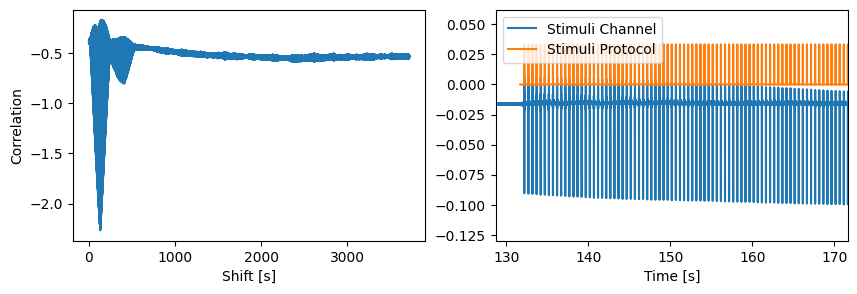

Time Shift:  131.68


In [17]:
shift_time_clicks = finding_shift(protocol_clicks)
print("Time Shift: ", shift_time_clicks)

In [18]:
# clicks are played each 0.5s for 2 min -> calculate all shifts/onsets
shifts = [shift_time_clicks + 0.5*i for i in range(1, 241)]

#### Creating the Event Array

In [19]:
# generate events for the clicks
## shape: 3 dimensional array for each click
_, time_eeg = eeg_data.get_data(picks="eeg", return_times=True)
events_clicks = np.zeros((len(shifts), 3), dtype=int)
## first value: shifts in time (find closest possible existing time point in data)
events_clicks[:, 0] = [np.argmin(np.abs(np.array(time_eeg) - i)) for i in shifts]
## third value: event code (here: zeros for each click)
events_clicks[:, 2] = np.ones(len(shifts))

#### Extracting the Epochs

In [20]:
# get epochs: data sections from tmin before until tmax after onset for each event
#TODO: insert the time for tmin and tmax for selecting the time interval around the stimuli onsets
tmin = -0.5
tmax = 1
epochs_clicks_standard = mne.Epochs(eeg_data, events_clicks, tmin=tmin, tmax=tmax, picks="eeg", preload=True,
                            reject=dict(eeg=0.0001))

Not setting metadata
240 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 240 events and 301 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
4 bad epochs dropped


#### Calculating the ERP

In [23]:
# plot the average clicks ERP
%matplotlib qt
# calculate average
evoked_clicks = epochs_clicks_standard.average(picks="eeg", method="mean")
evoked_clicks.filter(bandPassFilterLow, bandPassFilterHigh)
with mne.viz.use_browser_backend("matplotlib"):
    evoked_clicks.plot()

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_4544\143796522.py:5: RuntimeWarning: filter_length (661) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_clicks.filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


### Words Phonemes Pure Tones

In [24]:
#TODO: insert the path for stimuli protocol Stimulus_Words_Phonemes_Harry_Potter.npy
protocol_words = np.load(basePath + "Stimulus_Words_Phonemes_Harry_Potter.npy")
protocol_words = np.dstack((protocol_words[2], protocol_words[2]))[0].T

#### Finding the time points for each pure tone, phoneme and word

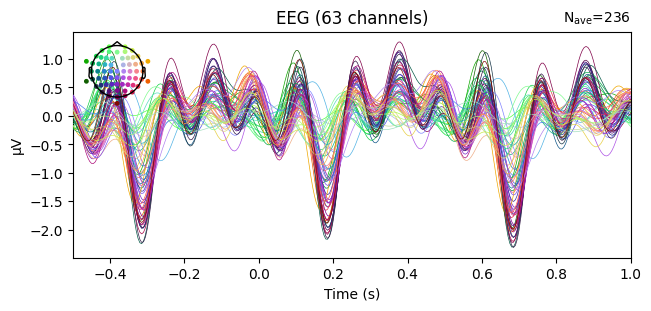

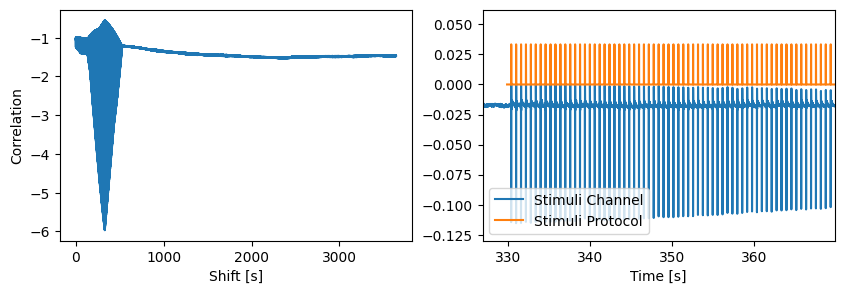

Time Shift:  329.885


In [25]:
shift_time = finding_shift(protocol_words)
print("Time Shift: ", shift_time)

In [26]:
# pure tone, phonemes and words are played randomly 30 times (11 stimuli * 30) with 0.6s spacing
shifts = [shift_time+0.5 + 0.6*i for i in range(30*11)]
shifts

[np.float64(330.385),
 np.float64(330.985),
 np.float64(331.585),
 np.float64(332.185),
 np.float64(332.78499999999997),
 np.float64(333.385),
 np.float64(333.985),
 np.float64(334.585),
 np.float64(335.185),
 np.float64(335.78499999999997),
 np.float64(336.385),
 np.float64(336.985),
 np.float64(337.585),
 np.float64(338.185),
 np.float64(338.78499999999997),
 np.float64(339.385),
 np.float64(339.985),
 np.float64(340.585),
 np.float64(341.185),
 np.float64(341.78499999999997),
 np.float64(342.385),
 np.float64(342.985),
 np.float64(343.585),
 np.float64(344.185),
 np.float64(344.78499999999997),
 np.float64(345.385),
 np.float64(345.985),
 np.float64(346.585),
 np.float64(347.185),
 np.float64(347.78499999999997),
 np.float64(348.385),
 np.float64(348.985),
 np.float64(349.585),
 np.float64(350.185),
 np.float64(350.78499999999997),
 np.float64(351.385),
 np.float64(351.985),
 np.float64(352.585),
 np.float64(353.185),
 np.float64(353.78499999999997),
 np.float64(354.385),
 np.float6

#### Creating the Event Code

In [27]:
# getting the labels for each stimulus
#TODO: insert the path for the transcript of the stimuli protocol Stim_list_single_Words_HP.txt
path = basePath + 'Stim_list_single_Words_HP.txt'
with open(path) as f:
        lines = f.readlines()
lines = [l.split("\n")[0] for l in lines]
lines

['the',
 'freq_1000',
 'p',
 'possible',
 'd',
 'Dursley',
 'son',
 'p',
 'freq_5000',
 'Dursley',
 'd',
 's',
 'the',
 'freq_3000',
 'Dursley',
 'Dursley',
 'the',
 'p',
 'freq_1000',
 'freq_1000',
 'the',
 'Dursley',
 'Dursley',
 'freq_5000',
 'd',
 's',
 'p',
 'freq_3000',
 'son',
 'possible',
 'Dursley',
 'freq_5000',
 'freq_5000',
 'freq_3000',
 'freq_3000',
 'possible',
 'packed',
 'son',
 'freq_1000',
 'son',
 'd',
 'packed',
 'Dursley',
 'possible',
 's',
 's',
 'freq_3000',
 'freq_3000',
 'the',
 'possible',
 'packed',
 'son',
 's',
 's',
 'freq_5000',
 'possible',
 'Dursley',
 'Dursley',
 'Dursley',
 'the',
 'son',
 'freq_5000',
 'freq_1000',
 'freq_3000',
 'possible',
 'p',
 'freq_1000',
 'freq_5000',
 'freq_3000',
 'freq_1000',
 'p',
 'd',
 'son',
 'freq_3000',
 'd',
 'p',
 'the',
 'freq_1000',
 'p',
 'd',
 'packed',
 'Dursley',
 'freq_3000',
 'freq_5000',
 'packed',
 'possible',
 'p',
 's',
 'freq_1000',
 'Dursley',
 'd',
 'freq_5000',
 'freq_3000',
 'the',
 'son',
 'Dursl

In [28]:
# creating a dictionary with all stimuli
stimuli = list(set(lines))
event_code = {}
for index, element in enumerate(stimuli):
    event_code[element] = index
event_code

{'son': 0,
 'the': 1,
 'freq_3000': 2,
 'freq_1000': 3,
 'p': 4,
 'possible': 5,
 'freq_5000': 6,
 'packed': 7,
 'Dursley': 8,
 'd': 9,
 's': 10}

In [29]:
# getting the code for each label
code = [event_code[l] for l in lines]
code

[1,
 3,
 4,
 5,
 9,
 8,
 0,
 4,
 6,
 8,
 9,
 10,
 1,
 2,
 8,
 8,
 1,
 4,
 3,
 3,
 1,
 8,
 8,
 6,
 9,
 10,
 4,
 2,
 0,
 5,
 8,
 6,
 6,
 2,
 2,
 5,
 7,
 0,
 3,
 0,
 9,
 7,
 8,
 5,
 10,
 10,
 2,
 2,
 1,
 5,
 7,
 0,
 10,
 10,
 6,
 5,
 8,
 8,
 8,
 1,
 0,
 6,
 3,
 2,
 5,
 4,
 3,
 6,
 2,
 3,
 4,
 9,
 0,
 2,
 9,
 4,
 1,
 3,
 4,
 9,
 7,
 8,
 2,
 6,
 7,
 5,
 4,
 10,
 3,
 8,
 9,
 6,
 2,
 1,
 0,
 8,
 1,
 10,
 1,
 1,
 8,
 7,
 0,
 3,
 10,
 6,
 1,
 1,
 5,
 4,
 1,
 9,
 5,
 6,
 10,
 5,
 2,
 4,
 1,
 3,
 10,
 8,
 5,
 6,
 1,
 7,
 4,
 8,
 2,
 10,
 2,
 0,
 9,
 2,
 4,
 8,
 6,
 7,
 3,
 6,
 4,
 7,
 10,
 7,
 5,
 0,
 0,
 4,
 7,
 7,
 5,
 10,
 7,
 5,
 7,
 2,
 10,
 7,
 7,
 9,
 3,
 9,
 10,
 5,
 5,
 3,
 7,
 2,
 0,
 9,
 2,
 7,
 1,
 3,
 9,
 3,
 5,
 10,
 0,
 0,
 6,
 0,
 9,
 2,
 5,
 1,
 4,
 10,
 6,
 4,
 3,
 7,
 6,
 3,
 4,
 8,
 4,
 10,
 2,
 7,
 3,
 0,
 9,
 9,
 6,
 2,
 9,
 2,
 2,
 10,
 6,
 7,
 4,
 1,
 1,
 6,
 3,
 4,
 0,
 1,
 7,
 5,
 0,
 6,
 1,
 6,
 7,
 3,
 3,
 8,
 5,
 1,
 4,
 4,
 1,
 3,
 0,
 4,
 10,
 10,
 7,
 5,
 5,
 5,
 4

#### Creating the Event Array

In [30]:
# generate events for the clicks
## shape: 3 dimensional array for each stimulus
_, time_eeg = eeg_data.get_data(picks="eeg", return_times=True)
events_words = np.zeros((len(shifts), 3), dtype=int)
## first value: shifts in time (find closest possible existing time point in data)
events_words[:, 0] = [np.argmin(np.abs(np.array(time_eeg) - i)) for i in shifts]
## third value: event code (code for each stimuli)
events_words[:, 2] = np.array(code)

#### Extracting the Epochs

In [31]:
#TODO: insert the time for tmin and tmax for selecting the time interval around the stimuli onsets
#TODO: insert the event code as event_id
epochs_words = mne.Epochs(eeg_data, events_words, event_id=event_code, tmin=tmin, tmax=tmax, picks="eeg", preload=True,
                            reject=dict(eeg=0.0001))   # event_id is the dictionary for our event code

Not setting metadata
330 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 330 events and 301 original time points ...
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
7 bad epochs dropped


In [32]:
# some information about the epochs like the number for each stimulus, the time range...
epochs_words

<Epochs | 323 events (all good), -0.5 – 1 s (baseline -0.5 – 0 s), ~46.8 MB, data loaded,
 'son': 30
 'the': 29
 'freq_3000': 28
 'freq_1000': 30
 'p': 30
 'possible': 28
 'freq_5000': 30
 'packed': 30
 'Dursley': 29
 'd': 30
 and 1 more events ...>

#### Calculating the ERP

In [33]:
%matplotlib qt
# calculating average
words_average = epochs_words.average(method="mean", by_event_type=True)
from scipy.fft import fft, ifft
'''
#TODO: insert the index for the word 'packed'
packed = words_average[8].filter(bandPassFilterLow, bandPassFilterHigh) #depending on the index you can chose different words/freq/phonemes

#TODO: plot the ERP

fig = packed.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('packed')
#TODO: insert the index for the freq3000
freq3000 = words_average[9].filter(bandPassFilterLow, bandPassFilterHigh)
#TODO: plot the ERP
#plt.title('freq3000')
fig = freq3000.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('freq3000')

'''


"\n#TODO: insert the index for the word 'packed'\npacked = words_average[8].filter(bandPassFilterLow, bandPassFilterHigh) #depending on the index you can chose different words/freq/phonemes\n\n#TODO: plot the ERP\n\nfig = packed.plot(ylim=dict(eeg=[-8, 8]))\nfig.suptitle('packed')\n#TODO: insert the index for the freq3000\nfreq3000 = words_average[9].filter(bandPassFilterLow, bandPassFilterHigh)\n#TODO: plot the ERP\n#plt.title('freq3000')\nfig = freq3000.plot(ylim=dict(eeg=[-8, 8]))\nfig.suptitle('freq3000')\n\n"

##### ERPs for every stimuli

In [36]:
freq1000 = words_average[7].filter(bandPassFilterLow, bandPassFilterHigh)
fig = freq1000.plot(ylim=dict(eeg=[-8, 8]))


fig.suptitle('freq1000')
freq1000

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3329195511.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  freq1000 = words_average[7].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Evoked | 'd' (average, N=30), -0.1 – 0.7 s, baseline -0.1 – 0 s, 63 ch, ~172 kB>

In [61]:
def comp_fft(meanERPSignal):
    fs = 200
    N = len(meanERPSignal)  # Length of the signal
    fft_result = np.fft.fft(meanERPSignal)
    frequencies = np.fft.fftfreq(N, d=1/fs)  # Frequency axis

    # Compute amplitude spectrum
    amplitude_spectrum = np.abs(fft_result) / N
    positive_frequencies = frequencies[:N//2]  # Take positive frequencies
    positive_amplitudes = 2 * amplitude_spectrum[:N//2]  # Double for single-sided spectrum

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_frequencies[0:40], positive_amplitudes[0:40], marker='.', markersize=10)
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    pass

In [38]:
meanFreq1000 = freq1000.data
meanFreq1000 = np.mean(meanFreq1000, axis=1)

comp_fft(meanERPSignal=meanFreq1000)


In [39]:
freq3000 = words_average[5].filter(bandPassFilterLow, bandPassFilterHigh)
fig = freq3000.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('freq3000')


Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3012845970.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  freq3000 = words_average[5].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Text(0.5, 0.98, 'freq3000')

In [40]:
meanFreq3000 = freq3000.data
meanFreq3000 = np.mean(meanFreq3000, axis=1)
comp_fft(meanERPSignal=meanFreq3000)

In [41]:
freq5000 = words_average[0].filter(bandPassFilterLow, bandPassFilterHigh)
fig = freq5000.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('freq5000')

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\1402779056.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  freq5000 = words_average[0].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Text(0.5, 0.98, 'freq5000')

In [42]:
meanFreq5000 = freq5000.data
meanFreq5000 = np.mean(meanFreq5000, axis=1)



In [43]:
s = words_average[1].filter(bandPassFilterLow, bandPassFilterHigh)
fig = s.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('s')
meanStimS = s.data
meanStimS = np.mean(meanStimS, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3776695991.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  s = words_average[1].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [44]:
son = words_average[2].filter(bandPassFilterLow, bandPassFilterHigh)
fig = son.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('son')
meanStimSon = son.data
meanStimSon = np.mean(meanStimSon, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\116601422.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  son = words_average[2].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [45]:
the = words_average[3].filter(bandPassFilterLow, bandPassFilterHigh)
fig = the.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('the')
meanStimThe = the.data
meanStimThe = np.mean(meanStimThe, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3043972269.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  the = words_average[3].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [46]:
d = words_average[6].filter(bandPassFilterLow, bandPassFilterHigh)
fig = d.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('d')
meanStimD = d.data
meanStimD = np.mean(meanStimD, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3432477541.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  d = words_average[6].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [47]:
Dursley = words_average[4].filter(bandPassFilterLow, bandPassFilterHigh)
fig = Dursley.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('Dursley')
meanStimDursley = Dursley.data
meanStimDursley = np.mean(meanStimDursley, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\3442381748.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  Dursley = words_average[4].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [48]:
p = words_average[10].filter(bandPassFilterLow, bandPassFilterHigh)
fig = p.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('p')
meanStimP = p.data
meanStimP = np.mean(meanStimP, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\1576032358.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  p = words_average[10].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [49]:
packed = words_average[9].filter(bandPassFilterLow, bandPassFilterHigh)
fig = packed.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('packed')
meanStimPacked = packed.data
meanStimPacked = np.mean(meanStimPacked, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\2278056108.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  packed = words_average[9].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [50]:
possible = words_average[8].filter(bandPassFilterLow, bandPassFilterHigh)
fig = possible.plot(ylim=dict(eeg=[-8, 8]))
fig.suptitle('possible')
meanStimPossible = possible.data
meanStimPossible = np.mean(meanStimPossible, axis=1)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_17260\1432534603.py:1: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  possible = words_average[8].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [51]:
plt.plot(meanFreq1000, label='1000')
plt.plot(meanFreq3000, label='3000')
plt.plot(meanFreq5000, label='5000')
plt.legend()
plt.show()
correlationMatrix = np.corrcoef([meanFreq1000, meanFreq3000, meanFreq5000])
correlationMatrix

array([[ 1.        ,  0.26142442,  0.36845704],
       [ 0.26142442,  1.        , -0.01890292],
       [ 0.36845704, -0.01890292,  1.        ]])

In [52]:
plt.plot(meanStimD, label='d')
plt.plot(meanStimP, label='p')
plt.plot(meanStimS, label='s')
plt.legend()
plt.show()

In [53]:
plt.plot(meanStimDursley, label='Dursley')
plt.plot(meanStimThe, label='the')
plt.plot(meanStimPacked, label='packed')
plt.plot(meanStimPossible, label='possible')
plt.legend()
plt.show()
correlationMatrix = np.corrcoef([meanStimDursley, meanStimThe, meanStimPacked, meanStimPossible])
correlationMatrix

array([[ 1.        , -0.32698199,  0.23875395,  0.26470524],
       [-0.32698199,  1.        ,  0.19585747,  0.2843489 ],
       [ 0.23875395,  0.19585747,  1.        ,  0.35674209],
       [ 0.26470524,  0.2843489 ,  0.35674209,  1.        ]])

In [54]:
plt.plot(meanStimD, label='d')
plt.plot(meanStimP, label='p')
plt.plot(meanStimS, label='s')
plt.plot(meanFreq1000, label='1000')
plt.plot(meanFreq3000, label='3000')
plt.plot(meanFreq5000, label='5000')
plt.legend()
plt.show()
correlationMatrix = np.corrcoef([meanStimD, meanStimP, meanStimS, meanFreq1000, meanFreq3000, meanFreq5000])
correlationMatrix

array([[ 1.        ,  0.59230138,  0.61043846,  0.48756637,  0.75711986,
         0.06022014],
       [ 0.59230138,  1.        ,  0.4889495 ,  0.45195349,  0.5958054 ,
         0.13447121],
       [ 0.61043846,  0.4889495 ,  1.        ,  0.61097101,  0.34305269,
         0.22746686],
       [ 0.48756637,  0.45195349,  0.61097101,  1.        ,  0.26142442,
         0.36845704],
       [ 0.75711986,  0.5958054 ,  0.34305269,  0.26142442,  1.        ,
        -0.01890292],
       [ 0.06022014,  0.13447121,  0.22746686,  0.36845704, -0.01890292,
         1.        ]])

In [55]:
comp_fft(meanERPSignal=meanFreq1000)
comp_fft(meanERPSignal=meanFreq3000)
comp_fft(meanERPSignal=meanFreq5000)
comp_fft(meanERPSignal=meanStimD)
comp_fft(meanERPSignal=meanStimP)
comp_fft(meanERPSignal=meanStimS)


# Source Reconstruction

In [34]:
# selecting the evoked file you want to reconstruct in source space
evoked = evoked_clicks.copy() # if you want to reconstruct freq_5000: evoked = words_average[0].copy()
evoked.set_eeg_reference("average", projection=True)
evoked.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<Evoked | '1' (average, N=236), -0.5 – 1 s, baseline -0.5 – 0 s, 63 ch, ~243 kB>

### Fetch fsAverage

In [35]:
# fsaverage is a template brain from FreeSurfer (https://surfer.nmr.mgh.harvard.edu/)
fs_dir = fetch_fsaverage()
fs_subject_dir = op.dirname(fs_dir)
fs_subject = "fsaverage"

0 files missing from root.txt in C:\Users\jakob\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage


### Noise Covariance

In [36]:
# calculating the noise covariance from the 1 min silence before the first test (clicks)
eeg_data.set_eeg_reference("average", projection=True)
noise_cov = mne.compute_raw_covariance(eeg_data, tmin=shift_time_clicks-60, tmax=shift_time_clicks)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Using up to 300 segments
Number of samples used : 12000
[done]


### Boundary Element Model from fsAverage

In [37]:
# loading the boundary element model from fsaverage
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

In [38]:
# plotting a bem solution
# bem surfaces are the triangulations of the interfaces between different tissues needed for the forward computation
# these surfaces can be for example inner skull, outer skull and skalp surface
%matplotlib qt
with mne.viz.use_browser_backend("matplotlib"):
    mne.viz.plot_bem(subject=fs_subject, subjects_dir=fs_subject_dir, orientation='coronal')

Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


### Volume Source Space (Cortex Area using aseg volume atlas)

In [39]:
# using the Aseg-Atlas to select every brain region that lies in the cortex
#TODO: complete the path to the atlas
aseg_fname = "C:/Users/jakob/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz"
labels = mne.get_volume_labels_from_aseg(aseg_fname)
labels = [label for label in labels if label.startswith("ctx")]  #ctx short for cortex

In [40]:
# source space defines the position and orientation of the candidate source locations
# there are two types of source spaces: surface-based (where the candidates are confined to a surface) and
# volumetric (when the candidates are discrete, arbitrarily located source points bounded by the surface)
# here we set up a volume source space with pos=5 -> source grid with 5mm spacing
vol_src = mne.setup_volume_source_space(
    fs_subject, pos=5, subjects_dir=fs_subject_dir, bem=bem, add_interpolator=True, volume_label=labels, mri=aseg_fname, single_volume=True
)

BEM              : C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : C:/Users/jakob/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz

Reading C:/Users/jakob/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz...

Loaded inner skull from C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif (2562 nodes)
Surface CM = (  -0.5  -21.1    6.2) mm
Surface fits inside a sphere with radius   98.3 mm
Surface extent:
    x =  -75.2 ...   76.3 mm
    y = -113.3 ...   75.0 mm
    z =  -71.7 ...   88.2 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y = -115.0 ...   75.0 mm
    z =  -75.0 ...   90.0 mm
43758 sources before omitting any.
29824 sources after omitting infeasible sources not within 0.0 - 98.3 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at lea

In [63]:
# plotting the volume source space
#vol_src.plot()

In [41]:
# plotting the sources and bem on the fsaverage brain
%matplotlib qt
with mne.viz.use_browser_backend("matplotlib"):
    mne.viz.plot_bem(subject=fs_subject, subjects_dir=fs_subject_dir, src=vol_src, orientation='coronal')

Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\jakob\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


#### Calculating the Source Estimate

In [42]:
# make forward solution out of info-file, volume source space and bem
forward = mne.make_forward_solution(info=evoked.info, trans='fsaverage', src=vol_src, bem=bem, eeg=True)

Source space          : <SourceSpaces: [<volume (ctx_lh_G_and_S_frontomargin+ctx_lh_G_and_S_occipital_inf+ctx_lh_G_and_S_paracentral+ctx_lh_G_and_S_subcentral+ctx_lh_G_and_S_transv_frontopol+ctx_lh_G_and_S_cingul-Ant+ctx_lh_G_and_S_cingul-Mid-Ant+ctx_lh_G_and_S_cingul-Mid-Post+ctx_lh_G_cingul-Post-dorsal+ctx_lh_G_cingul-Post-ventral+ctx_lh_G_cuneus+ctx_lh_G_front_inf-Opercular+ctx_lh_G_front_inf-Orbital+ctx_lh_G_front_inf-Triangul+ctx_lh_G_front_middle+ctx_lh_G_front_sup+ctx_lh_G_Ins_lg_and_S_cent_ins+ctx_lh_G_insular_short+ctx_lh_G_occipital_middle+ctx_lh_G_occipital_sup+ctx_lh_G_oc-temp_lat-fusifor+ctx_lh_G_oc-temp_med-Lingual+ctx_lh_G_oc-temp_med-Parahip+ctx_lh_G_orbital+ctx_lh_G_pariet_inf-Angular+ctx_lh_G_pariet_inf-Supramar+ctx_lh_G_parietal_sup+ctx_lh_G_postcentral+ctx_lh_G_precentral+ctx_lh_G_precuneus+ctx_lh_G_rectus+ctx_lh_G_subcallosal+ctx_lh_G_temp_sup-G_T_transv+ctx_lh_G_temp_sup-Lateral+ctx_lh_G_temp_sup-Plan_polar+ctx_lh_G_temp_sup-Plan_tempo+ctx_lh_G_temporal_inf+ctx_lh

In [43]:
# make inverse operator using info-file forward solution and noise covariance with depth weighting=4
inv = mne.minimum_norm.make_inverse_operator(info=evoked.info, forward=forward, noise_cov=noise_cov, depth=4)

Computing inverse operator with 63 channels.
    63 out of 63 channels remain after picking
Selected 63 channels
Creating the depth weighting matrix...
    63 EEG channels
    limit = 2683/2682 = 2.279244
    scale = 115865 exp = 4
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 3.9e-14 (2.2e-16 eps * 63 dim * 2.8  max singular value)
    Estimated rank (eeg): 61
    EEG: rank 61 computed from 63 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.67343
    scaling factor to adjust the trace = 4.21162e+18 (nchan = 63 nzero = 2)


In [44]:
# calculating the source estimate (the reconstruction) using the evoked array and the inverse operator
# with regularization parameter of 0.1 and method="sLORETA"
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=0.1, method="sLORETA")

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 236
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 61 (2 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Applying inverse operator to "1"...
    Picked 63 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  63.2% variance
    Combining the current components...
    sLORETA...
[done]


stc.data shape: (2682, 301)
vol_src shapes: [2682]
Fixing initial time: 0.19 s
Showing: t = 0.190 s, (-55.0, -40.0, -30.0) mm, [5, 15, 9] vox, 12083 vertex
Using control points [0.91410768 0.98587874 1.53601881]


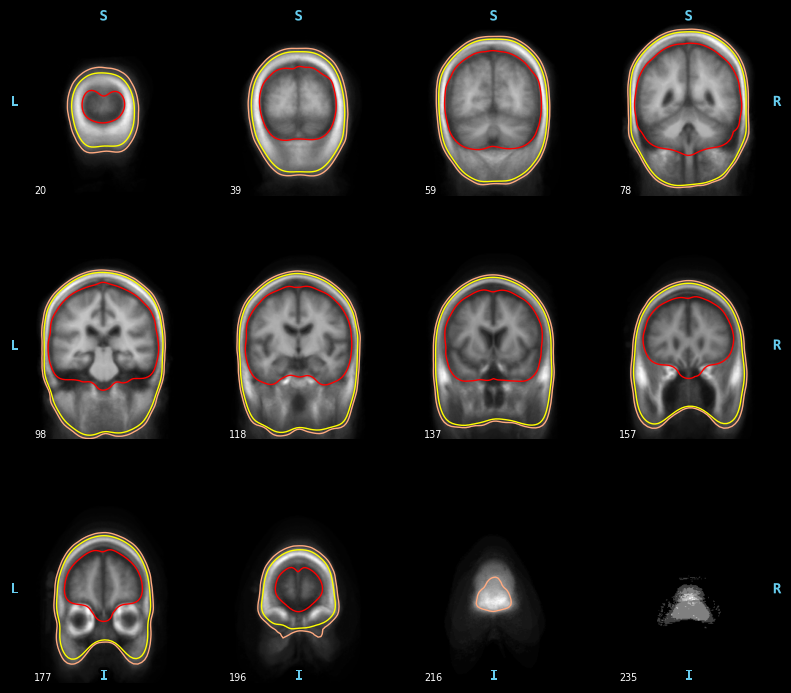

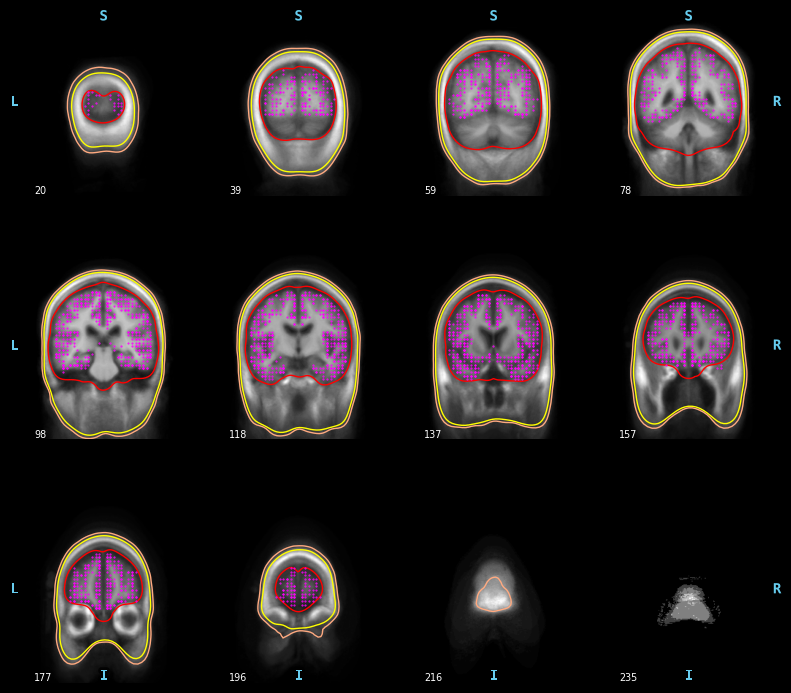

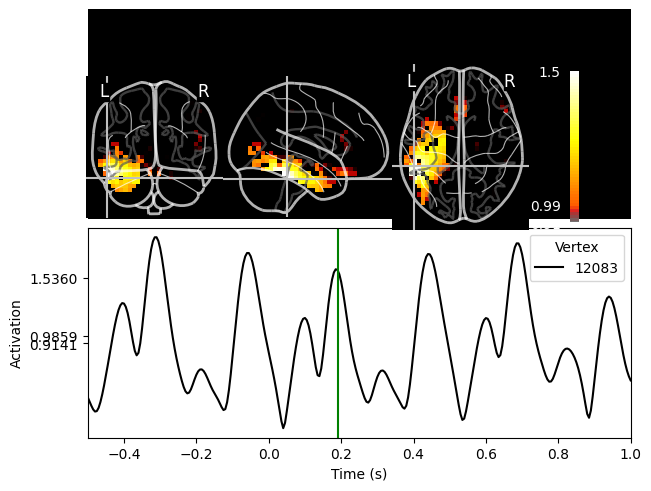

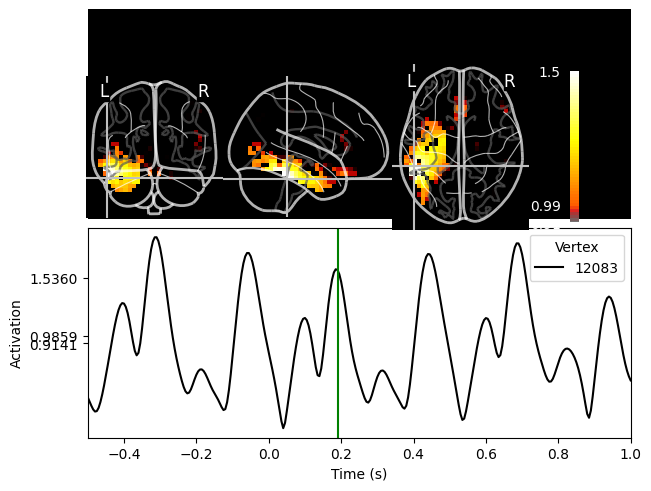

In [46]:
# plotting the source reconstruction
%matplotlib inline
#TODO: set the time you want to view...Hint: look at the ERP in sensor space
kwargs = dict(
    src=vol_src,
    subject="fsaverage",
    subjects_dir=fs_subject_dir,
    initial_time=0.19,
    verbose=True,
)
print(f"stc.data shape: {stc.data.shape}")
print(f"vol_src shapes: {[len(src['vertno']) for src in vol_src]}")

stc.plot(mode="glass_brain", **kwargs, show=True)

# Extra work for audiobook

In [47]:

from scipy.io import wavfile
wav_filename = basePath + "audio_files/Harry_Potter_Audio1.wav"  # Replace with your WAV file path
sample_rate, audio_data = wavfile.read(wav_filename)
print(sample_rate)
audioBookProtocolPath = basePath + "Harry_Potter_Audio1_Protocol.npy"
np.save(audioBookProtocolPath, audio_data)
print(f"Audio data saved to {audioBookProtocolPath}.")
audioBookProtocol = np.transpose(audio_data)
row2 = audioBookProtocol[1]
audioBookProtocol = np.vstack([audioBookProtocol, row2])



44100
Audio data saved to C:/StudyMaster/SeminarStimulate/EEG_analysis/Harry_Potter_Audio1_Protocol.npy.


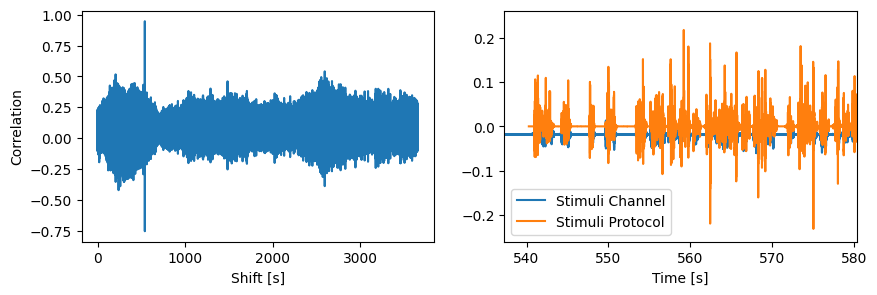

Time Shift:  540.28


In [48]:
shift_time_audioBook = finding_shift(audioBookProtocol)
print("Time Shift: ", shift_time_audioBook)

In [49]:
import textgrid

# Load the TextGrid file
tg = textgrid.TextGrid()
tg.read(basePath+"text_files/Harry_Potter_Audio1.TextGrid")
#print(tg.tiers[0])
shiftArray = np.empty((0, 3), dtype=object)

for interval in tg.tiers[0]:
    print(f"Interval start: {interval.minTime}, end: {interval.maxTime}, label: {interval.mark}")
    if interval.mark != "":
        new_row = np.array([[interval.minTime, interval.maxTime, interval.mark]])
        shiftArray = np.vstack((shiftArray, new_row))

shiftArray[:, 0] = shiftArray[:, 0].astype(float) + shift_time_audioBook
shiftArray[:, 1] = shiftArray[:, 1].astype(float) + shift_time_audioBook




Interval start: 0.0, end: 0.6, label: 
Interval start: 0.6, end: 0.95, label: harry
Interval start: 0.95, end: 1.49, label: potter
Interval start: 1.49, end: 1.58, label: 
Interval start: 1.58, end: 1.73, label: and
Interval start: 1.73, end: 1.81, label: the
Interval start: 1.81, end: 2.53, label: philosopher's
Interval start: 2.53, end: 3.11, label: stone
Interval start: 3.11, end: 3.94, label: 
Interval start: 3.94, end: 4.12, label: by
Interval start: 4.12, end: 4.4, label: j
Interval start: 4.4, end: 4.67, label: k
Interval start: 4.67, end: 5.18, label: rowling
Interval start: 5.18, end: 7.34, label: 
Interval start: 7.34, end: 7.69, label: chapter
Interval start: 7.69, end: 8.08, label: one
Interval start: 8.08, end: 9.34, label: 
Interval start: 9.34, end: 9.44, label: the
Interval start: 9.44, end: 10.02, label: boy
Interval start: 10.02, end: 10.07, label: 
Interval start: 10.07, end: 10.18, label: who
Interval start: 10.18, end: 10.79, label: lived
Interval start: 10.79, end

In [51]:

nlp = spacy.load('en_core_web_sm')

with open(basePath +"audio_files/Harry_Potter_Audio1.txt", "r") as file:
    text = file.read()
text
text = text.replace('\n', ' ').strip()
textRef = text

doc = nlp(text)
# Print each word and its part-of-speech (POS) tag
wordLabel = np.empty((0, 2), dtype=object)
print(f"{'Token':<15}{'POS Tag':<15}")
print("-" * 30)
for token in doc:
    print(f"{token.text:<15}{token.pos_:<15}")
    new_row = np.array([[token.text, token.pos_]])
    wordLabel = np.vstack((wordLabel,new_row))


# Check which strings start with the specified character
char = "'"
wordLabel = wordLabel.astype(str)

indices_with_apostrophe = np.argwhere(np.char.find(wordLabel, "'") != -1)
indices_with_dash = np.argwhere(np.char.find(wordLabel, "-") != -1)
indices = np.vstack((indices_with_apostrophe, indices_with_dash))
indices = np.unique(indices, axis=0)

#np.argwhere(np.char.find(wordLabel, "-") != -1)
print(indices)
rows_to_delete = indices[:, 0]
rows_to_delete = np.unique(rows_to_delete)
rows_to_delete = np.sort(rows_to_delete)[::-1]

wordLabel_cleaned = np.delete(wordLabel, rows_to_delete, axis=0)
wordCompare = [wordLabel_cleaned[:,0],shiftArray[:,2]]
shiftArray = np.hstack((shiftArray, wordLabel_cleaned[:, 1].reshape(-1, 1)))


Token          POS Tag        
------------------------------
Harry          PROPN          
Potter         PROPN          
and            CCONJ          
the            DET            
Philosopher    PROPN          
's             PART           
Stone          PROPN          
by             ADP            
J.             PROPN          
K.             PROPN          
Rowling        PROPN          
chapter        NOUN           
one            NUM            
The            DET            
boy            NOUN           
who            PRON           
lived          VERB           
Mr             PROPN          
and            CCONJ          
Mrs            PROPN          
Dursley        PROPN          
of             ADP            
number         NOUN           
four           NUM            
Privet         PROPN          
Drive          PROPN          
were           AUX            
proud          ADJ            
to             PART           
say            VERB           
that    

In [ ]:
# Initialize recognizer
recognizer = sr.Recognizer()

# Load the audio file
with sr.AudioFile('processedHPA.wav') as source:
    audio_data = recognizer.record(source)

# Transcribe audio to text
text = recognizer.recognize_google(audio_data)

# Compare with word list and find approximate timings
word_list = [textRef]
transcribed_words = text.split()

aligned_words = []
for word in word_list:
    if word in transcribed_words:
        aligned_words.append(word)

print(aligned_words)

In [52]:
'''path = basePath + 'audio_files/Harry_Potter_Audio1.txt'
with open(path) as f:
        lines = f.readlines()
lines = [l.split("\n")[0] for l in lines]'''
lines = shiftArray[:,3]
lines 


array(['PROPN', 'PROPN', 'CCONJ', 'DET', 'PROPN', 'PROPN', 'ADP', 'PROPN',
       'PROPN', 'PROPN', 'NOUN', 'NUM', 'DET', 'NOUN', 'PRON', 'VERB',
       'PROPN', 'CCONJ', 'PROPN', 'PROPN', 'ADP', 'NOUN', 'NUM', 'PROPN',
       'PROPN', 'AUX', 'ADJ', 'PART', 'VERB', 'SCONJ', 'PRON', 'AUX',
       'ADV', 'ADJ', 'VERB', 'PRON', 'ADV', 'ADV', 'PRON', 'AUX', 'DET',
       'ADJ', 'NOUN', 'PRON', 'VERB', 'PART', 'AUX', 'VERB', 'ADP',
       'PRON', 'ADJ', 'CCONJ', 'ADJ', 'SCONJ', 'PRON', 'ADV', 'AUX',
       'VERB', 'ADP', 'ADJ', 'NOUN', 'PROPN', 'PROPN', 'AUX', 'DET',
       'NOUN', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', 'PRON', 'VERB',
       'NOUN', 'PRON', 'AUX', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'ADV',
       'DET', 'NOUN', 'SCONJ', 'PRON', 'AUX', 'VERB', 'DET', 'ADV', 'ADJ',
       'NOUN', 'PROPN', 'PROPN', 'AUX', 'ADJ', 'CCONJ', 'ADJ', 'CCONJ',
       'VERB', 'ADV', 'DET', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'PRON',
       'VERB', 'ADP', 'ADV', 'ADJ', 'SCONJ', 'PRON', 'VERB', 'ADV', 

In [53]:
stimuli = list(set(lines))
event_code = {}
for index, element in enumerate(stimuli):
    event_code[element] = index
event_code

{'PRON': 0,
 'PROPN': 1,
 'ADP': 2,
 'AUX': 3,
 'PART': 4,
 'SCONJ': 5,
 'ADV': 6,
 'INTJ': 7,
 'CCONJ': 8,
 'VERB': 9,
 'NOUN': 10,
 'NUM': 11,
 'ADJ': 12,
 'DET': 13}

In [54]:
code = [event_code[l] for l in lines]
code

[1,
 1,
 8,
 13,
 1,
 1,
 2,
 1,
 1,
 1,
 10,
 11,
 13,
 10,
 0,
 9,
 1,
 8,
 1,
 1,
 2,
 10,
 11,
 1,
 1,
 3,
 12,
 4,
 9,
 5,
 0,
 3,
 6,
 12,
 9,
 0,
 6,
 6,
 0,
 3,
 13,
 12,
 10,
 0,
 9,
 4,
 3,
 9,
 2,
 0,
 12,
 8,
 12,
 5,
 0,
 6,
 3,
 9,
 2,
 12,
 10,
 1,
 1,
 3,
 13,
 10,
 2,
 13,
 10,
 9,
 10,
 0,
 9,
 10,
 0,
 3,
 13,
 12,
 12,
 10,
 2,
 6,
 13,
 10,
 5,
 0,
 3,
 9,
 13,
 6,
 12,
 10,
 1,
 1,
 3,
 12,
 8,
 12,
 8,
 9,
 6,
 13,
 13,
 12,
 10,
 2,
 10,
 0,
 9,
 2,
 6,
 12,
 5,
 0,
 9,
 6,
 12,
 2,
 0,
 10,
 9,
 2,
 10,
 10,
 9,
 2,
 13,
 10,
 13,
 1,
 9,
 13,
 12,
 10,
 9,
 1,
 8,
 2,
 0,
 10,
 0,
 9,
 13,
 12,
 10,
 6,
 13,
 1,
 9,
 0,
 0,
 9,
 8,
 0,
 6,
 9,
 13,
 10,
 8,
 0,
 12,
 10,
 3,
 5,
 0,
 3,
 9,
 0,
 0,
 3,
 9,
 0,
 3,
 9,
 0,
 5,
 0,
 9,
 2,
 2,
 13,
 1,
 1,
 1,
 3,
 1,
 1,
 10,
 8,
 0,
 3,
 9,
 2,
 12,
 10,
 2,
 10,
 1,
 1,
 9,
 0,
 3,
 9,
 13,
 10,
 5,
 0,
 10,
 8,
 0,
 12,
 2,
 0,
 10,
 3,
 6,
 12,
 5,
 0,
 3,
 12,
 4,
 3,
 13,
 1,
 9,
 4,
 9,
 0,
 13,
 10,
 3,

In [55]:
_, time_eeg = eeg_data.get_data(picks="eeg", return_times=True)
events_words = np.zeros((len(shiftArray[:,0]), 3), dtype=int)
events_words[:, 0] = [np.argmin(np.abs(np.array(time_eeg) - i)) for i in shiftArray[:,0]]
events_words[:, 2] = np.array(code)

In [56]:
epochs_words = mne.Epochs(eeg_data, events_words, event_id=event_code, tmin=tmin, tmax=tmax, picks="eeg", preload=True,
                            reject=dict(eeg=0.0001))

Not setting metadata
419 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 419 events and 301 original time points ...
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'T8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P2', 'CPz', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'Iz']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 

In [57]:
epochs_words

<Epochs | 406 events (all good), -0.5 – 1 s (baseline -0.5 – 0 s), ~58.8 MB, data loaded,
 'PRON': 48
 'PROPN': 48
 'ADP': 36
 'AUX': 25
 'PART': 6
 'SCONJ': 14
 'ADV': 22
 'INTJ': 1
 'CCONJ': 18
 'VERB': 56
 and 4 more events ...>

In [58]:

words_average = epochs_words.average(method="mean", by_event_type=True)
bandPassFilterLow = 1
bandPassFilterHigh = 8



In [59]:
def moving_average(signal, window_size):
    moving_avg = []
    for i in range(len(signal) - window_size + 1):
        window = signal[i:i + window_size]
        avg = np.mean(window)
        moving_avg.append(avg)
    return np.array(moving_avg)

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_4544\3437962423.py:2: RuntimeWarning: filter_length (661) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.
  nouns = words_average[13].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


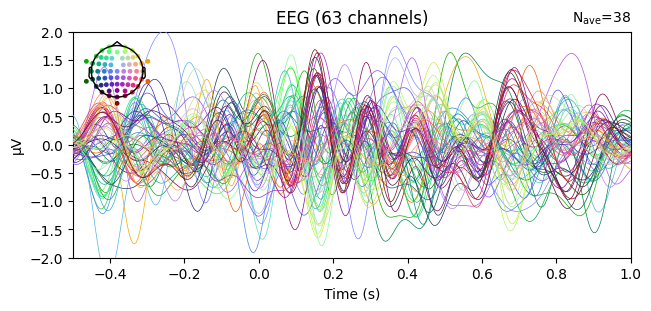

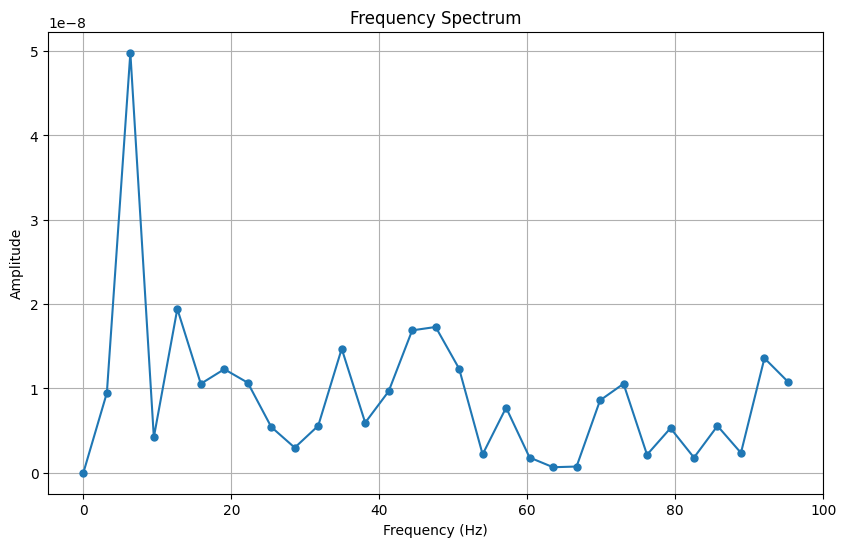

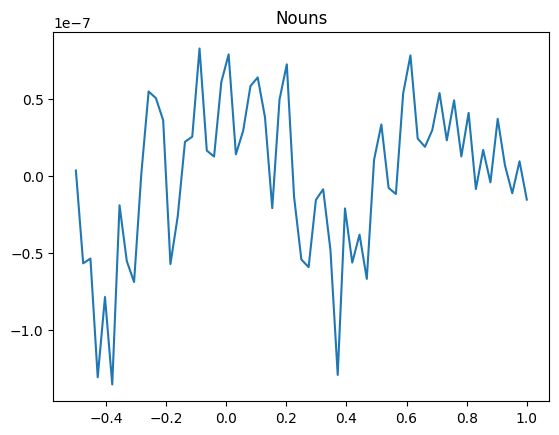

In [64]:
%matplotlib inline
nouns = words_average[13].filter(bandPassFilterLow, bandPassFilterHigh)
fig = nouns.plot(ylim=dict(eeg=[-2, 2]))

fig.suptitle('Nouns')

meanNouns = nouns.data
meanNouns = np.mean(meanNouns, axis=1)
#meanNouns = moving_average(meanNouns,10)
comp_fft(meanERPSignal=meanNouns)
time_vector = np.linspace(tmin, tmax, len(meanNouns))
plt.title('Nouns')
plt.plot(time_vector, meanNouns, label='Nouns')
plt.show()

Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (3.305 s)



C:\Users\jakob\AppData\Local\Temp\ipykernel_4544\2678080187.py:1: RuntimeWarning: filter_length (661) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.
  verbs = words_average[1].filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


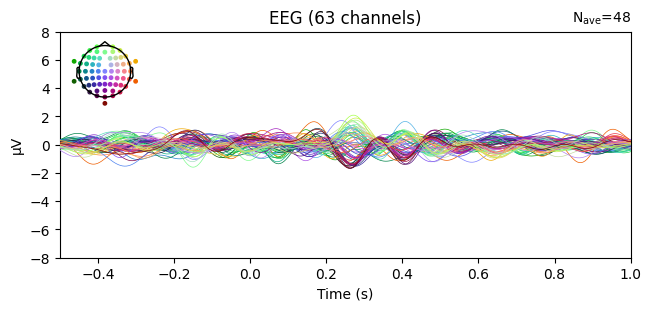

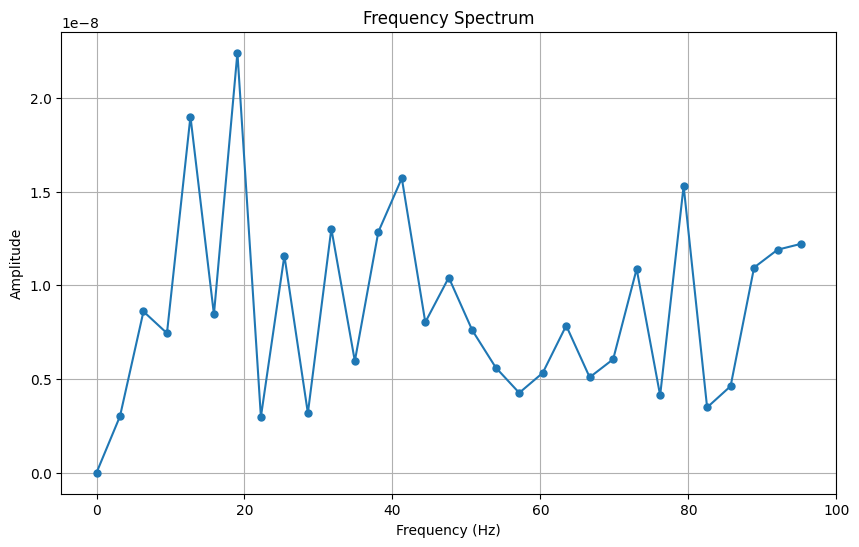

array([[-3.36165491e-08, -7.92695615e-09,  1.90105470e-08, ...,
        -3.14411137e-07, -2.89900766e-07, -2.60782838e-07],
       [-7.99476007e-08, -5.99479601e-08, -3.75697700e-08, ...,
        -2.55216145e-07, -2.32773851e-07, -2.05363449e-07],
       [-3.59577122e-08,  2.14669420e-08,  8.19310532e-08, ...,
        -5.60875038e-07, -5.32527764e-07, -4.95763221e-07],
       ...,
       [-8.71783476e-08, -1.37800773e-07, -1.92489471e-07, ...,
        -6.19333541e-08, -3.34440232e-08, -6.40174747e-09],
       [-1.83360370e-07, -2.12349310e-07, -2.42117593e-07, ...,
        -3.00110865e-07, -2.66364715e-07, -2.31619488e-07],
       [ 8.58582180e-08,  6.76828405e-08,  4.75254781e-08, ...,
         2.62069478e-07,  2.30965354e-07,  2.00496887e-07]])

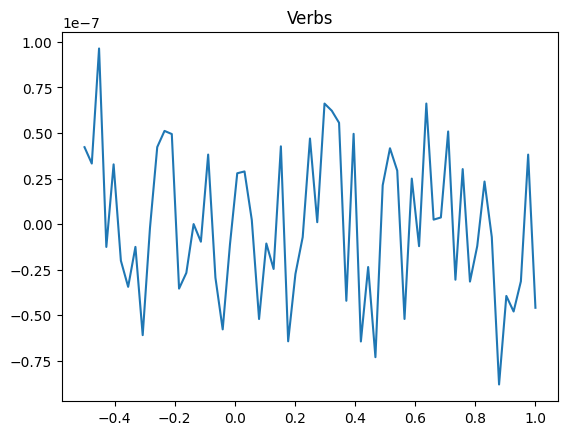

In [65]:

verbs = words_average[1].filter(bandPassFilterLow, bandPassFilterHigh)
fig = verbs.plot(ylim=dict(eeg=[-8, 8]))

fig.suptitle('Verbs')
meanVerbs = verbs.data
meanVerbs = np.mean(meanVerbs, axis=1)
#meanVerbs = moving_average(meanVerbs,7)
comp_fft(meanERPSignal=meanVerbs)
time_vector = np.linspace(tmin, tmax, len(meanVerbs))
plt.title('Verbs')
plt.plot(time_vector, meanVerbs, label='Verbs')
verbs.data

Setting up band-pass filter from 1 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 661 samples (3.305 s)

Setting up band-pass filter from 1 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filt

C:\Users\jakob\AppData\Local\Temp\ipykernel_19704\1061783623.py:6: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  nouns_average.filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\jakob\AppData\Local\Temp\ipykernel_19704\1061783623.py:7: RuntimeWarning: filter_length (661) is longer than the signal (161), distortion is likely. Reduce filter length or filter a longer signal.
  verbs_average.filter(bandPassFilterLow, bandPassFilterHigh)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


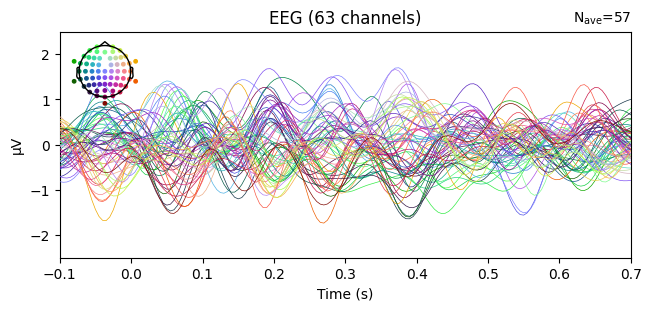

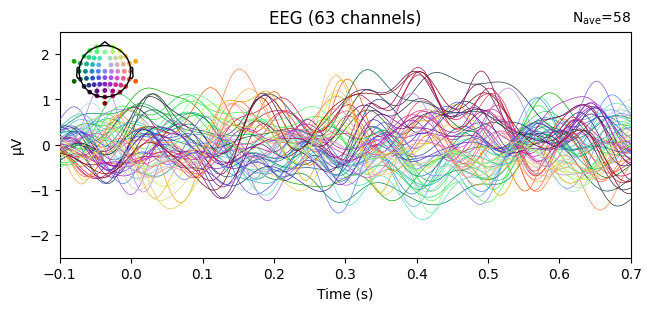

In [157]:


epochs_words_nouns = epochs_words["NOUN"]
epochs_words_verbs = epochs_words["VERB"]
nouns_average = epochs_words_nouns.average(method="mean")
verbs_average = epochs_words_verbs.average(method="mean")
nouns_average.filter(bandPassFilterLow, bandPassFilterHigh)
verbs_average.filter(bandPassFilterLow, bandPassFilterHigh)
with mne.viz.use_browser_backend("matplotlib"):
    nouns_average.plot(ylim=dict(eeg=[-2.5, 2.5]))
    verbs_average.plot(ylim=dict(eeg=[-2.5, 2.5]))

    